In [31]:
%load_ext autoreload
%autoreload 2


import numpy as np
import pandas as pd

from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Our very own survLime!
import survLime
from survLime.utils.generic_utils import fill_matrix_with_total_times
from survLime.datasets.load_datasets import Loader 
from survLime import survlime_tabular


loader = Loader(dataset_name='veterans')
x,events, times = loader.load_data()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/carlos.hernandez/dl/lib/python3.8/site-packages/pandas/core/series.py:4530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [32]:
train, val, test = loader.preprocess_datasets(x, events, times)
events_train = [x[0] for x in train[1]]
times_train  = [x[1] for x in train[1]]

events_val = [x[0] for x in val[1]]
times_val  = [x[1] for x in val[1]]

events_test = [x[0] for x in test[1]]
times_test  = [x[1] for x in test[1]]

In [40]:
len(events_train)
len(times_test)

28

In [33]:
model = CoxPHSurvivalAnalysis(alpha=0.0001)
#model = RandomSurvivalForest()
model.fit(train[0], train[1])
model.score(test[0], test[1])

0.7154696132596685

## Code trials to have it all on the explainer


In [26]:
from tqdm import tqdm

times_to_fill = list(set(times_train)); times_to_fill.sort()
columns = test[0].columns.tolist()
num_pat = 200

explainer = survlime_tabular.LimeTabularExplainer(train[0], target_data=train[1], feature_names=columns, class_names=None,
                                                   categorical_features=None, verbose=True, mode='regression', discretize_continuous=False)
compt_weights = []
for test_point in tqdm(test[0].values):
    H_i_j_wc, weights, log_correction, Ho_t_, scaled_data = \
                    explainer.explain_instance(test_point, model.predict_survival_function, num_samples = num_pat)
    
    b_ = explainer.solve_opt_problem(H_i_j_wc, weights, log_correction, Ho_t_, scaled_data, verbose=False)
    compt_weights.append(b_)
    

  0%|                                                                                                                                                                                        | 0/34 [00:00<?, ?it/s]/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
  3%|█████▏                                                                                                                                                                          | 1/34 [00:48<26:51, 48.84s/it]

time solving the problem 47.86941253498662


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
  6%|██████████▎                                                                                                                                                                     | 2/34 [01:33<24:37, 46.16s/it]

time solving the problem 43.142209356999956


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
  9%|███████████████▌                                                                                                                                                                | 3/34 [02:22<24:39, 47.72s/it]

time solving the problem 48.407716125948355


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 12%|████████████████████▋                                                                                                                                                           | 4/34 [03:09<23:46, 47.55s/it]

time solving the problem 46.125701363082044


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 15%|█████████████████████████▉                                                                                                                                                      | 5/34 [03:54<22:31, 46.60s/it]

time solving the problem 43.77078059397172


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 18%|███████████████████████████████                                                                                                                                                 | 6/34 [04:43<22:01, 47.19s/it]

time solving the problem 47.153446353040636


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 21%|████████████████████████████████████▏                                                                                                                                           | 7/34 [05:29<21:09, 47.02s/it]

time solving the problem 45.53046307899058


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 24%|█████████████████████████████████████████▍                                                                                                                                      | 8/34 [06:16<20:20, 46.96s/it]

time solving the problem 45.65152034594212


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 26%|██████████████████████████████████████████████▌                                                                                                                                 | 9/34 [07:03<19:32, 46.90s/it]

time solving the problem 45.58906811696943


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 29%|███████████████████████████████████████████████████▍                                                                                                                           | 10/34 [07:49<18:38, 46.62s/it]

time solving the problem 44.83017311897129


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 32%|████████████████████████████████████████████████████████▌                                                                                                                      | 11/34 [08:39<18:13, 47.53s/it]

time solving the problem 48.40382867900189


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 35%|█████████████████████████████████████████████████████████████▊                                                                                                                 | 12/34 [09:25<17:20, 47.28s/it]

time solving the problem 45.52970330696553


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 38%|██████████████████████████████████████████████████████████████████▉                                                                                                            | 13/34 [10:14<16:44, 47.84s/it]

time solving the problem 47.967825888074


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 41%|████████████████████████████████████████████████████████████████████████                                                                                                       | 14/34 [11:00<15:40, 47.03s/it]

time solving the problem 43.97505598096177


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 44%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 15/34 [11:49<15:06, 47.71s/it]

time solving the problem 48.121749173034914


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 47%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 16/34 [12:36<14:13, 47.41s/it]

time solving the problem 45.53375189809594


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 17/34 [13:22<13:21, 47.15s/it]

time solving the problem 45.346816389937885


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 53%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 18/34 [14:11<12:40, 47.54s/it]

time solving the problem 47.2889560990734


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 19/34 [14:59<11:56, 47.75s/it]

time solving the problem 47.04509109200444


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 20/34 [15:45<11:03, 47.41s/it]

time solving the problem 45.433308792999014


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 21/34 [16:34<10:22, 47.86s/it]

time solving the problem 47.73710829997435


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 22/34 [17:21<09:30, 47.55s/it]

time solving the problem 45.63130500901025


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 23/34 [18:08<08:39, 47.25s/it]

time solving the problem 45.36456931999419


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 24/34 [18:56<07:55, 47.51s/it]

time solving the problem 46.93147626204882


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 25/34 [19:44<07:09, 47.72s/it]

time solving the problem 47.02396618202329


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 26/34 [20:31<06:19, 47.43s/it]

time solving the problem 45.57447500003036


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 27/34 [21:19<05:33, 47.71s/it]

time solving the problem 47.18192396010272


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 28/34 [22:08<04:48, 48.04s/it]

time solving the problem 47.62610996409785


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 29/34 [22:55<03:58, 47.66s/it]

time solving the problem 45.57179899397306


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 30/34 [23:43<03:11, 47.88s/it]

time solving the problem 47.21241987799294


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 31/34 [24:30<02:22, 47.66s/it]

time solving the problem 45.962419465067796


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 32/34 [25:15<01:33, 46.83s/it]

time solving the problem 43.71524105302524


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 33/34 [26:04<00:47, 47.44s/it]

time solving the problem 47.65846757404506


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [26:54<00:00, 47.48s/it]

time solving the problem 48.54495249397587


In [27]:
computation_veterans_2 = pd.DataFrame(compt_weights, columns=columns)

#computation_veterans_2.to_csv('/home/carlos.hernandez/PhD/SurvLIME/udca_2_surv_weights.csv', index=False)

In [36]:
#computation_veteran.mean().to_numpy()
computation_veterans_2 = pd.read_csv('/home/carlos.hernandez/PhD/SurvLIME/veterans_surv_weights.csv')

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=3.96842e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=9.98832e-18): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=1.52627e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=2.03557e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,


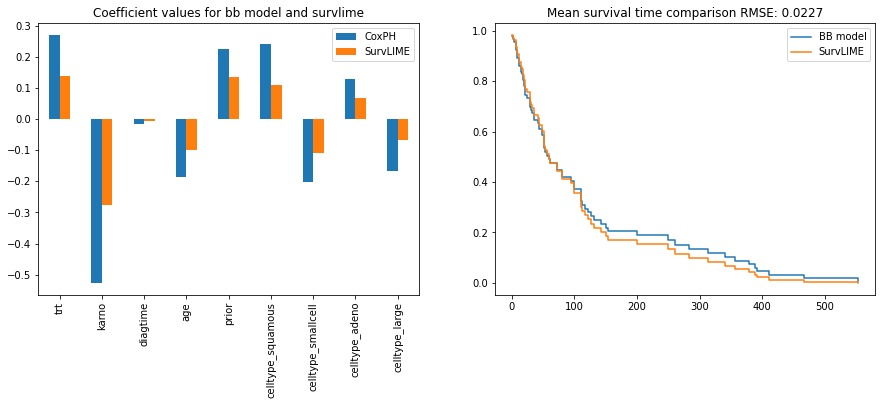

In [38]:
from survLime.utils.generic_utils import compare_survival_times

compare_survival_times(model, computation_veterans_2.mean(), train[0], train[1], test[0])

### Old code
#### It will get deleted eventually, now it's there for reference.

In [ ]:
# 


from sksurv.nonparametric import nelson_aalen_estimator
from functools import partial
import cvxpy as cp
from math import log
import timeit
import sklearn

# Step one
Ho_t_ = nelson_aalen_estimator(events_train, times_train)[0] # Unique times [0]; CHF [1]

columns = test[0].columns.tolist()
num_pat = 500

# Step two
explainer = survlime_tabular.LimeTabularExplainer(train[0], target_data=train[1], feature_names=columns, class_names=None,
                                                   categorical_features=None, verbose=True, mode='regression', discretize_continuous=False)

synthetic_data = explainer.data_inverse(test[0].iloc[0], num_pat) # At [0] we have the data and at [1]
                                                        #the inverse, see what is this
    
# Third step: Obtain the prediction for the synthetic data 
H_i_j = model.predict_cumulative_hazard_function(synthetic_data[1]) # X_test_t -> [371, num_features]

times_to_fill = list(set(times_train)); times_to_fill.sort()


#Ho_t_ = [fill_matrix_with_total_times(times_to_fill, times_train, list(x.x)) for x in Ho_t_]
H_i_j_wc = [fill_matrix_with_total_times(times_to_fill, x.y, list(x.x)) for x in H_i_j]

In [ ]:
# Step two
from sksurv.nonparametric import nelson_aalen_estimator
from functools import partial
import cvxpy as cp
from math import log
import timeit
import sklearn

times_to_fill = list(set(times_train)); times_to_fill.sort()
columns = test[0].columns.tolist()
num_pat = 500

explainer = survlime_tabular.LimeTabularExplainer(train[0], target_data=train[1], feature_names=columns, class_names=None,
                                                   categorical_features=None, verbose=True, mode='regression', discretize_continuous=False)

H_i_j_wc, weights, log_correction, Ho_t_, scaled_data = \
                    explainer.explain_instance(test[0].iloc[0], model.predict_survival_function)